# MANOVA Test

> Use Case:
- Evaluating the impact of two categorical independent variables (Factors A and B) on a continuous dependent variable.
- Assessing interactions between Factor A and Factor B, as well as their individual effects.

> Assumptions:
1. Normality: The residuals are normally distributed.
2. Homogeneity of Variances: The variances of the residuals are constant across all levels of the factors.
3. Independence: Observations are independent of each other.

> Example Scenario (A/B/C/D Test):
- Factors:
  - Factor A (e.g., Different Versions of a Website)
  - Factor B (e.g., Time of Day)
- Dependent Variable: Continuous metric (e.g., User Engagement)

> Null Hypothesis (H0):
- There is no significant difference in the means of the dependent variable across different levels of Factor A, Factor B, or their interaction.

> Alternative Hypothesis (H1):
- At least one of the means of the dependent variable is different across different levels of Factor A, Factor B, or their interaction.

> Interpretation:
- If the p-value is below the chosen significance level (e.g., 0.05), reject the null hypothesis.
- Significant p-values indicate that there is evidence of a significant difference in means, either due to Factor A, Factor B, or their interaction.

> When to Use:
- When there are two categorical independent variables (Factors A and B) influencing a continuous dependent variable.
- Useful for investigating main effects and interaction effects simultaneously.

In [225]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.multivariate.manova import MANOVA

# !pip install scipy==1.12.0
from scipy.stats import bartlett

# !pip install pingouin==0.5.5
import pingouin as pg
from pingouin import multivariate_normality

In [227]:
# Set random seed for reproducibility
np.random.seed(42)

In [228]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'yellowgreen'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [229]:
# Set parameters for power analysis
alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Number of groups (treatments) in the MANOVA
num_groups = 3

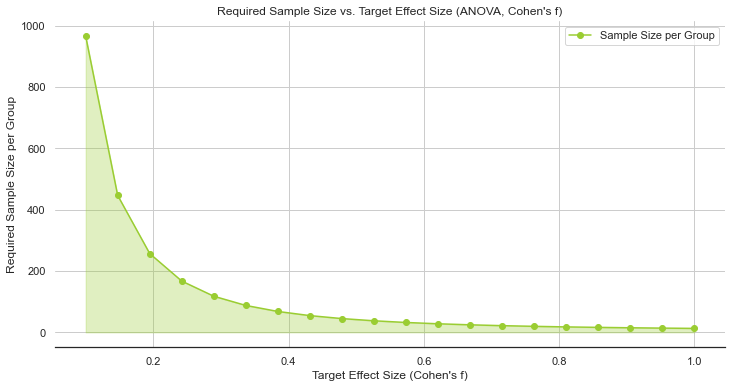

In [230]:
# Define a range of effect sizes to explore
effect_sizes = np.linspace(0.1, 1.0, 20) # From small to large effect sizes

# Initialize an empty list to store the calculated sample sizes
sample_sizes = []

# Iterate over the effect sizes and calculate the required sample size for each
for effect in effect_sizes:
    # Perform power analysis to calculate sample size
    analysis = FTestAnovaPower()
    n = analysis.solve_power(effect_size=effect, alpha=alpha, nobs=None, k_groups=num_groups, power=power)
    if n is not None:
        sample_sizes.append(n)
    else:
        sample_sizes.append(np.nan) # Append NaN if calculation fails

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size per Group')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Target Effect Size (ANOVA, Cohen\'s f)')
plt.xlabel('Target Effect Size (Cohen\'s f)')
plt.ylabel('Required Sample Size per Group')
plt.grid(True)
plt.legend()
plt.show()

In [231]:
# Let's say we anticipate a small effect size (Cohen's f = 0.1)
effect = 0.1

# Perform power analysis to calculate sample size
analysis = FTestAnovaPower()
sample_size_per_group = int(round(analysis.solve_power(effect_size=effect, alpha=alpha, nobs=None, k_groups=num_groups, power=power), 0))

print(f"Sample size needed per group: {sample_size_per_group}")

Sample size needed per group: 966


### Synthetic Data

In [ ]:
# Number of samples per group
n_samples = sample_size_per_group

In [243]:
# Intervention groups (A, B, C)
interventions = np.repeat(['A', 'B', 'C'], n_samples)

# Group A: Centered around (10, 30, 50) with smaller variance
X1_A = np.random.normal(10, 2, n_samples)
X2_A = np.random.normal(30, 3, n_samples)
X3_A = np.random.normal(50, 8, n_samples)
# Group B: Centered around (10.5, 30.5, 50.5) - very close to A
X1_B = np.random.normal(10.5, 2, n_samples)
X2_B = np.random.normal(30.5, 3, n_samples)
X3_B = np.random.normal(50.5, 8, n_samples)
# Group C: Centered around (11, 31, 51) - also close to A and B
X1_C = np.random.normal(11, 2, n_samples)
X2_C = np.random.normal(31, 3, n_samples)
X3_C = np.random.normal(51, 8, n_samples)

X1 = np.concatenate([X1_A, X1_B, X1_C])
X2 = np.concatenate([X2_A, X2_B, X2_C])
X3 = np.concatenate([X3_A, X3_B, X3_C])

# Create a pandas DataFrame
manova_data = pd.DataFrame({'Intervention': interventions, 'CTR': X1, 'Time': X2, 'Spend': X3})

manova_data


,Intervention,CTR,Time,Spend
0,A,9.930872,29.844136,60.398970
1,A,11.811435,30.844045,44.287666
2,A,14.691248,28.965051,57.447099
3,A,7.199858,30.681087,64.484180
4,A,9.792375,28.224372,59.719553
...,...,...,...,...
2893,C,11.844287,30.394677,47.846735
2894,C,10.502553,26.628482,38.062786
2895,C,12.669979,30.515716,46.784359
2896,C,12.699641,31.104308,53.219834


### Assumptions

In [ ]:

# Multivariate Normality Test using Henze-Zirkler
hz_result = multivariate_normality(manova_data[['CTR', 'Time', 'Spend']], alpha=0.05)
print("Henze-Zirkler Multivariate Normality Test:")
print(hz_result)


Henze-Zirkler Multivariate Normality Test:
HZResults(hz=0.9309706008967096, pval=0.3999226632400128, normal=True)


In [235]:
# Assumption 2: Homogeneity of variances (Bartlett's test)
bartlett_test_result = bartlett(manova_data[manova_data['Intervention']=='A']['CTR'].values, 
                                manova_data[manova_data['Intervention']=='B']['CTR'].values, 
                                manova_data[manova_data['Intervention']=='C']['CTR'].values)

is_homogeneous = bartlett_test_result.pvalue > 0.05

print(f'Homogeneity of Variances Test Result: {is_homogeneous}')

Homogeneity of Variances Test Result: True


In [236]:
# Assumption 2: Homogeneity of variances (Bartlett's test)
bartlett_test_result = bartlett(manova_data[manova_data['Intervention']=='A']['Time'].values, 
                                manova_data[manova_data['Intervention']=='B']['Time'].values, 
                                manova_data[manova_data['Intervention']=='C']['Time'].values)

is_homogeneous = bartlett_test_result.pvalue > 0.05

print(f'Homogeneity of Variances Test Result: {is_homogeneous}')

Homogeneity of Variances Test Result: True


In [237]:
# Assumption 2: Homogeneity of variances (Bartlett's test)
bartlett_test_result = bartlett(manova_data[manova_data['Intervention']=='A']['Spend'].values, 
                                manova_data[manova_data['Intervention']=='B']['Spend'].values, 
                                manova_data[manova_data['Intervention']=='C']['Spend'].values)

is_homogeneous = bartlett_test_result.pvalue > 0.05

print(f'Homogeneity of Variances Test Result: {is_homogeneous}')

Homogeneity of Variances Test Result: True


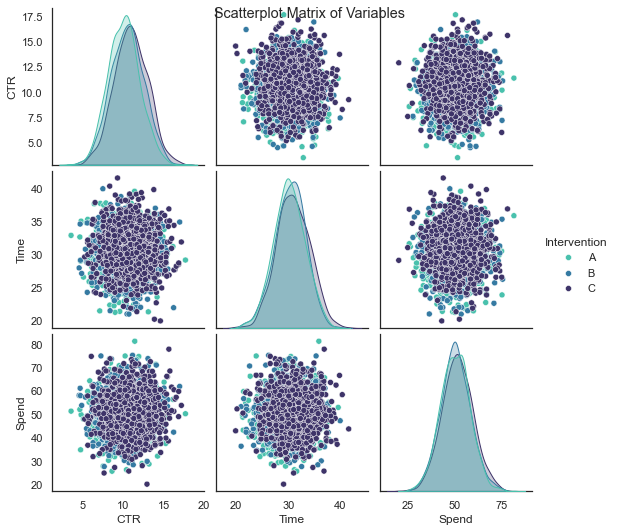

In [238]:
# Plot scatterplot matrix for visual inspection
sns.pairplot(manova_data, hue='Intervention', diag_kind='kde', palette='mako_r')
plt.suptitle('Scatterplot Matrix of Variables')
plt.show()

### MANOVA (statsmodels)

In [239]:
# Fit MANOVA model
manova_model = MANOVA.from_formula('CTR + Time + Spend ~ Intervention', data=manova_data)

# Perform multivariate analysis
result = manova_model.mv_test()

# Display results
print(result)

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value  Num DF   Den DF   F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda  0.0182 3.0000 2893.0000 51883.9130 0.0000
         Pillai's trace  0.9818 3.0000 2893.0000 51883.9130 0.0000
 Hotelling-Lawley trace 53.8029 3.0000 2893.0000 51883.9130 0.0000
    Roy's greatest root 53.8029 3.0000 2893.0000 51883.9130 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
          Intervention      Value  Num DF   Den DF  F Value Pr > F
------------------------------------------------------------------
              Wilks' lambda 0.9540 6.0000 5786.0000 22.9777 0.0000
             Pil

> Wilks' Lambda (λ): 
- This is a measure of how much variance in the dependent variables is not accounted for by the independent variables. Smaller values of λ indicate a stronger effect. A p-value associated with Wilks' Lambda tests the null hypothesis that there are no differences among the group means.
> Pillai's Trace (V): 
- Similar to Wilks' Lambda, Pillai's Trace is another measure of the amount of variance explained by the independent variables. Again, a smaller value indicates a stronger effect.
> Hotelling's Trace (T-squared): 
- This is a measure of the overall significance of the multivariate effect. A high T-squared value with a low p-value suggests a significant effect.
> Roy's Largest Root (R): 
- Roy's Largest Root is another statistic used to test the significance of the multivariate effect.

### Post-Hoc (statsmodels)

In [240]:
print("\nPost-Hoc Tests (Univariate ANOVAs with Tukey HSD correction):")

# Perform Post-Hoc tests for each dependent variable
dependent_vars = ['CTR', 'Time', 'Spend']
for var in dependent_vars:
    m_comp = pairwise_tukeyhsd(manova_data[var], manova_data['Intervention'], alpha=0.05)
    print(f"\nPost-Hoc for {var}:")
    print(m_comp)


Post-Hoc Tests (Univariate ANOVAs with Tukey HSD correction):

Post-Hoc for CTR:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     A      B   0.4077 0.001 0.1925 0.6229   True
     A      C   0.8691 0.001 0.6539 1.0843   True
     B      C   0.4614 0.001 0.2462 0.6766   True
-------------------------------------------------

Post-Hoc for Time:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B   0.1693 0.4448 -0.1568 0.4955  False
     A      C    0.769  0.001  0.4428 1.0951   True
     B      C   0.5997  0.001  0.2735 0.9258   True
---------------------------------------------------

Post-Hoc for Spend:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     

### Post-Hoc (pingouin)

In [241]:
print("\nPost-Hoc Tests (Univariate ANOVAs with Pingouin's pairwise_tukey):")

dependent_vars = ['CTR', 'Spend', 'Time']
alpha = 0.05

for dv in dependent_vars:
    print(f"\nPost-Hoc Tukey's HSD for Dependent Variable: {dv}")
    posthoc_tukey = pg.pairwise_tukey(data=manova_data, dv=dv, between='Intervention')
    display(posthoc_tukey)
    print("\nSignificant Differences:")
    for index, row in posthoc_tukey.iterrows():
        if row['p-tukey'] < alpha:
            print(f"  Significant difference found between groups {row['A']} and {row['B']} (p={row['p-tukey']:.3f})")
        else:
            print(f"  No significant difference found between groups {row['A']} and {row['B']} (p={row['p-tukey']:.3f})")


Post-Hoc Tests (Univariate ANOVAs with Pingouin's pairwise_tukey):

Post-Hoc Tukey's HSD for Dependent Variable: CTR


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,10.054788,10.462489,-0.407701,0.091758,-4.443212,0.000027,-0.204543
1,A,C,10.054788,10.923883,-0.869094,0.091758,-9.471572,0.000000,-0.432283
2,B,C,10.462489,10.923883,-0.461393,0.091758,-5.028360,0.000002,-0.225285



Significant Differences:
  Significant difference found between groups A and B (p=0.000)
  Significant difference found between groups A and C (p=0.000)
  Significant difference found between groups B and C (p=0.000)

Post-Hoc Tukey's HSD for Dependent Variable: Spend


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,50.103390,50.312223,-0.208833,0.365432,-0.571469,0.835340,-0.026430
1,A,C,50.103390,51.394637,-1.291247,0.365432,-3.533485,0.001211,-0.159581
2,B,C,50.312223,51.394637,-1.082414,0.365432,-2.962017,0.008652,-0.133494



Significant Differences:
  No significant difference found between groups A and B (p=0.835)
  Significant difference found between groups A and C (p=0.001)
  Significant difference found between groups B and C (p=0.009)

Post-Hoc Tukey's HSD for Dependent Variable: Time


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,30.164129,30.333455,-0.169326,0.139083,-1.217442,4.428965e-01,-0.056580
1,A,C,30.164129,30.933117,-0.768988,0.139083,-5.528983,1.051156e-07,-0.248346
2,B,C,30.333455,30.933117,-0.599663,0.139083,-4.311541,4.977350e-05,-0.194481



Significant Differences:
  No significant difference found between groups A and B (p=0.443)
  Significant difference found between groups A and C (p=0.000)
  Significant difference found between groups B and C (p=0.000)


### Visualization

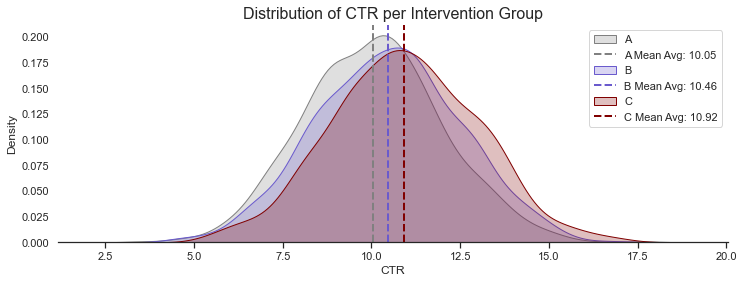

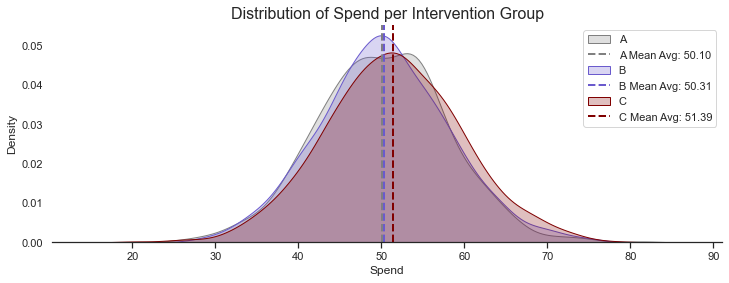

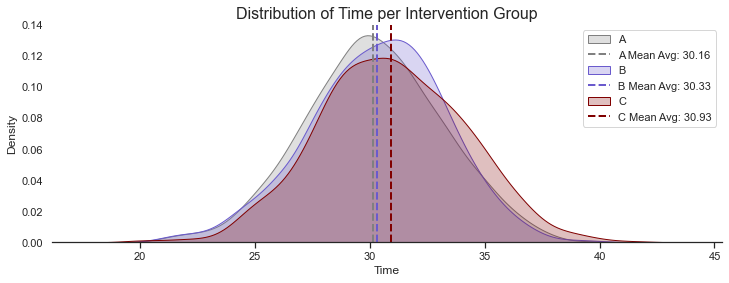

In [242]:
dependent_vars = ['CTR', 'Spend', 'Time']
intervention_groups = manova_data['Intervention'].unique()
colors = ['grey', 'slateblue', 'maroon', 'orange'] # Adjust as needed for the number of groups

for i, var in enumerate(dependent_vars):
    plt.figure(figsize=(12, 4))
    for j, group in enumerate(intervention_groups):
        subset = manova_data[manova_data['Intervention'] == group][var]
        sns.kdeplot(subset, label=group, fill=True, color=colors[j % len(colors)])
        mean_value = subset.mean()
        plt.axvline(mean_value, color=colors[j % len(colors)], linestyle='dashed', linewidth=2, label=f'{group} Mean Avg: {mean_value:.2f}')

    plt.title(f'Distribution of {var} per Intervention Group', fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.tick_params(left=False, bottom=True, labelleft=True, labelbottom=True)
    plt.legend()
    plt.show()